In [1]:
import numpy as np
import tensorflow as tf
from numpy import newaxis
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

In [2]:
class PPOAgent:
    def __init__(self, n_actions, n_features, action_low=-1, action_high=1, reward_decay=0.99,
                 actor_learning_rate=0.01, critic_learning_rate=0.01, learning_rate_decay=0.95,
                 ):
        self.state_size = n_features
        self.action_size = n_actions
        self.action_low = action_low
        self.action_high = action_high
        self.gamma = reward_decay   # discount rate
        self.actor_learning_rate = actor_learning_rate
        self.critic_learning_rate = critic_learning_rate # often larger than actor_learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.batch_size = 64
        self.epsilon = 0.2 # used to clip
        self.entfact = 1e-3 # entropy factor, to encourage exploration
        self.lam = 0.95 # gae factor
        self.memory = [] # store (s, a, r) for one agent
        self.agents = 5 # number of agents that collect memory
        self.history = {} # store the memory for different agents
        self.history['states'] = []
        self.history['actions'] = []
        self.history['discounted_rs'] = []
        self.history['advantages'] = []
        self._construct_nets()
        
    def _construct_nets(self):
        tf.reset_default_graph()
        self.sess = tf.Session()
        self.tfs = tf.placeholder(tf.float32, [None, self.state_size], 'state')

        # critic
        with tf.variable_scope('critic'):
            net = tf.layers.dense(self.tfs, 400, tf.nn.relu)
            net = tf.layers.dense(net, 50, tf.nn.relu)
#             net = tf.layers.dense(net, 1024, tf.nn.relu)
            self.v = tf.layers.dense(net, 1)
            self.tfdc_r = tf.placeholder(tf.float32, [None, 1], 'discounted_r')
            self.closs = tf.reduce_mean(tf.square(self.tfdc_r - self.v))
            self.ctrain_op = tf.train.AdamOptimizer(self.critic_learning_rate).minimize(self.closs)

        # actor
        pi, pi_params = self._build_anet('pi', trainable=True)
        test_pi = tf.distributions.Normal(loc=pi.mean(), scale=tf.zeros_like(pi.stddev()))
        oldpi, oldpi_params = self._build_anet('oldpi', trainable=False)
        with tf.variable_scope('sample_action'):
            self.sample_op = tf.squeeze(pi.sample(1), axis=0)       # choosing action
            self.sample_test = tf.squeeze(test_pi.sample(1), axis=0) # deterministic action in test
        with tf.variable_scope('update_oldpi'):
            self.update_oldpi_op = [oldp.assign(p) for p, oldp in zip(pi_params, oldpi_params)]

        self.tfa = tf.placeholder(tf.float32, [None, self.action_size], 'action')
        self.tfadv = tf.placeholder(tf.float32, [None, 1], 'advantage')
        with tf.variable_scope('loss'):
            with tf.variable_scope('surrogate'):
                self.ratio = pi.prob(self.tfa) / (oldpi.prob(self.tfa)+1e-10)
                surr = self.ratio * self.tfadv
                surr2 = tf.clip_by_value(self.ratio, 1-self.epsilon, 1+self.epsilon) * self.tfadv
                self.aloss = - tf.reduce_mean(tf.minimum(surr, surr2)) - self.entfact * tf.reduce_mean(pi.entropy())

        with tf.variable_scope('atrain'):
            self.atrain_op = tf.train.AdamOptimizer(self.actor_learning_rate).minimize(self.aloss, var_list=pi_params)

        self.saver = tf.train.Saver(max_to_keep=None)
        
        self.sess.run(tf.global_variables_initializer())
        
    def _build_anet(self, name, trainable):
        with tf.variable_scope(name):
            net = tf.layers.dense(self.tfs, 400, tf.nn.relu, trainable=trainable)
#             net = tf.layers.dense(net, 1024, tf.nn.relu, trainable=trainable)
            net = tf.layers.dense(net, 50, tf.nn.relu, trainable=trainable)
            mu = max(np.abs(self.action_low), np.abs(self.action_high)) * tf.layers.dense(net, self.action_size, tf.nn.tanh, trainable=trainable)
            sigma = tf.layers.dense(net, self.action_size, tf.nn.softplus, trainable=trainable)
            norm_dist = tf.distributions.Normal(loc=mu, scale=sigma)
        params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)
        return norm_dist, params
    
    def choose_action(self, state, train=True): # normal distribution
        if train:
            a = self.sess.run(self.sample_op, {self.tfs: state})[0]
        else:
            a = self.sess.run(self.sample_test, {self.tfs: state})[0]
        return np.clip(a, self.action_low, self.action_high)
    
    def remember(self, state, action, reward, next_state):
        self.memory += [[state[0], action, reward, next_state[0]]]
    
    def discount_rewards(self, rewards, gamma, value_next=0.0):
        discounted_r = np.zeros_like(rewards)
        running_add = value_next
        for t in reversed(range(0, len(rewards))):
            discounted_r[t] = running_add = running_add * gamma + rewards[t]
        return discounted_r
    
    def process_memory(self):
        memory = np.vstack(self.memory)
        states = np.vstack(memory[:,0])
        actions = np.vstack(memory[:,1])
        rewards = memory[:,2]
        last_next_state = memory[:,3][-1]
        discounted_ep_rs = self.discount_rewards(rewards, self.gamma)[:, newaxis]
        value_estimates = self.sess.run(self.v, {self.tfs: states}).flatten()
#         value_estimates = self.sess.run(self.v, {self.tfs: np.r_[states, last_next_state[newaxis, :]]}).flatten()
#         last_value_estimate = self.sess.run(self.v, {self.tfs: , self.obs: })[0]
        value_estimates = np.append(value_estimates, 0)
        delta_t = rewards + self.gamma * value_estimates[1:] - value_estimates[:-1]
        advs = self.discount_rewards(delta_t, self.gamma * self.lam)[:, newaxis] #gae
        last = states.shape[0]
        self.history['states'] += [states[-last:]]
        self.history['actions'] += [actions[-last:]]
        self.history['discounted_rs'] += [discounted_ep_rs[-last:]]
        self.history['advantages'] += [advs[-last:]]
        self.memory = [] # empty the memory
    
    def replay(self):
        self.sess.run(self.update_oldpi_op)
        
        s = np.vstack(self.history['states'])
        ac = np.vstack(self.history['actions'])
        dc_r = np.vstack(self.history['discounted_rs'])
        ad = np.vstack(self.history['advantages'])
#         ad = (ad-ad.mean())/ad.std()
        
        for _ in range(10): # update K epochs
            s, ac, dc_r, ad = shuffle(s, ac, dc_r, ad)
            for l in range(s.shape[0]//self.batch_size):
                start = l * self.batch_size
                end = (l + 1) * self.batch_size
                self.sess.run(self.atrain_op, {self.tfs: s[start:end], self.tfa: ac[start:end], self.tfadv: ad[start:end]})
                self.sess.run(self.ctrain_op, {self.tfs: s[start:end], self.tfdc_r: dc_r[start:end]})
            if s.shape[0] % self.batch_size != 0:
                res = s.shape[0] % self.batch_size
                self.sess.run(self.atrain_op, {self.tfs: s[-res:], self.tfa: ac[-res:], self.tfadv: ad[-res:]})
                self.sess.run(self.ctrain_op, {self.tfs: s[-res:], self.tfdc_r: dc_r[-res:]})
#         self.actor_learning_rate *= self.learning_rate_decay
#         self.critic_learning_rate *= self.learning_rate_decay
        
        for key in self.history:
            self.history[key] = [] # empty the history

In [3]:
env_name = "chase_game"
env = UnityEnvironment(file_name=env_name)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]
brain = env.brains[default_brain]

# Reset the environment
env_info = env.reset(train_mode=False)[default_brain]
    
# Examine the state space for the default brain
for i in range(env_info.states.shape[0]):
    print("Agent {}'s state looks like: \n{}".format(i+1, env_info.states[i]))

INFO:unityagents.environment:
'Academy' started successfully!


Unity Academy name: Academy
        Number of brains: 1
        Reset Parameters :
		
Unity brain name: Brain
        Number of observations (per agent): 0
        State space type: continuous
        State space size (per agent): 6
        Action space type: continuous
        Action space size (per agent): 2
        Memory space size (per agent): 0
        Action descriptions: , 
Agent 1's state looks like: 
[ 1.   0.   0.8  0.1 -1.2 -0.1]
Agent 2's state looks like: 
[ 0.   1.   0.8  0.1 -1.2 -0.1]


In [4]:
agent = PPOAgent(n_actions=2,
                n_features=6,
                action_high=1,
                action_low=-1,
                actor_learning_rate=1e-5,
                critic_learning_rate=2e-5,
                reward_decay=0.98
                )
rewards1 = []
rewards2 = []

# Train chaser using fixed dodger

In [6]:
# PPO
n_episodes = 1000

# agent.saver.restore(agent.sess, "model/model_bipedal2-2-10000.ckpt")
for i_episode in range(n_episodes):
    env_info = env.reset(train_mode=True)[default_brain]
    state1 = [env_info.states[0]]
#     state2 = [env_info.states[1]]
    r1 = r2 = 0
    while True:
        action1 = agent.choose_action(state1)
#         action2 = agent.choose_action(state2)
        action2 = np.array([0,0]) # fixed dodger
        env_info = env.step([action1, action2])[default_brain]
        next_state1 = [env_info.states[0]]
#         next_state2 = [env_info.states[1]]
        reward1 = env_info.rewards[0]
#         reward2 = env_info.rewards[1]
        done = env_info.local_done[0] or env_info.local_done[1]
        if not env_info.local_done[0] and env_info.local_done[1]: # dodger falls but chaser doesn't
            reward1 += 10
        r1 += reward1
#         r2 += reward2
        agent.remember(state1, action1, reward1, next_state1)
#         agent.remember(state2, action2, reward2, next_state2)
        state1 = next_state1
#         state2 = next_state2
        if done:
            print("episode:", i_episode+1, "rewards: chaser : %.2f, dodger : %.2f" % (r1, r2), end="\r")
            agent.process_memory()
            rewards1 += [r1]
#             rewards2 += [r2]
            break
    if (i_episode+1) % agent.agents == 0: # update every n_agent episodes
        agent.replay()
    if (i_episode+1) % 1000 == 0:
        agent.saver.save(agent.sess, "model/model_chaseronly_"+str(i_episode+1)+".ckpt");
print("\n")
print("finished learning!")

INFO:tensorflow:model/model_chaseronly_1000.ckpt is not in all_model_checkpoint_paths. Manually adding it.: chaser : 7.62, dodger : 0.00 344 rewards: chaser : 9.63, dodger : 0.00393 rewards: chaser : 6.71, dodger : 0.00 409 rewards: chaser : 8.17, dodger : 0.00 443 rewards: chaser : 8.29, dodger : 0.00 528 rewards: chaser : 7.93, dodger : 0.00 693 rewards: chaser : 8.99, dodger : 0.00 744 rewards: chaser : 9.57, dodger : 0.00 747 rewards: chaser : 9.76, dodger : 0.00 778 rewards: chaser : 8.61, dodger : 0.00 789 rewards: chaser : -10.12, dodger : 0.00rewards: chaser : 9.47, dodger : 0.00 rewards: chaser : 9.57, dodger : 0.00 901 rewards: chaser : 8.88, dodger : 0.00 938 rewards: chaser : 7.67, dodger : 0.00 964 rewards: chaser : 6.66, dodger : 0.00 966 rewards: chaser : 9.20, dodger : 0.00 995 rewards: chaser : 7.84, dodger : 0.00


INFO:tensorflow:model/model_chaseronly_1000.ckpt is not in all_model_checkpoint_paths. Manually adding it.




finished learning!


In [7]:
#ppo
n_episodes = 20

# test_rewards = []
agent.saver.restore(agent.sess, "model/model_chaseronly_1000.ckpt")
for i_episode in range(n_episodes):
    env_info = env.reset(train_mode=False)[default_brain]
    state1 = [env_info.states[0]]
#     state2 = [env_info.states[1]]
    r1 = r2 = 0
    while True:
        action1 = agent.choose_action(state1)
#         action2 = agent.choose_action(state2)
        action2 = np.array([0,0])
        env_info = env.step([action1, action2])[default_brain]
        next_state1 = [env_info.states[0]]
#         next_state2 = [env_info.states[1]]
        reward1 = env_info.rewards[0]
#         reward2 = env_info.rewards[1]
        done = env_info.local_done[0] or env_info.local_done[1]
        if not env_info.local_done[0] and env_info.local_done[1]: # dodger falls but chaser doesn't
            reward1 += 10
        r1 += reward1
#         r2 += reward2
        state1 = next_state1
#         state2 = next_state2
        if done:
            print("episode:", i_episode+1, "rewards: chaser : %.2f, dodger : %.2f" % (r1, r2), end="\r")
#             test_rewards += [r]
            break
print("\n")
print("finished testing!")

INFO:tensorflow:Restoring parameters from model/model_chaseronly_1000.ckpt


INFO:tensorflow:Restoring parameters from model/model_chaseronly_1000.ckpt


episode: 20 rewards: chaser : 6.11, dodger : 0.00

finished testing!


# Plot rewards

In [5]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n-1:] / n

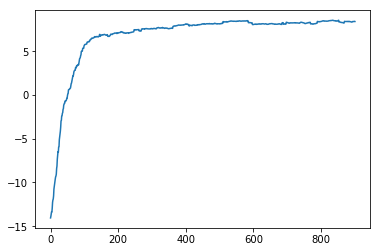

5.56662279977


In [8]:
# plt.plot(rewards1)
plt.plot(moving_average(rewards1, 100))
plt.show()
print(np.mean(rewards1))

# Train dodger using good chaser

In [6]:
agent2 = PPOAgent(n_actions=2,
                n_features=6,
                action_high=1,
                action_low=-1,
                actor_learning_rate=1e-5,
                critic_learning_rate=2e-5,
                reward_decay=0.98
                )

In [26]:
# PPO
n_episodes = 10000

# agent.saver.restore(agent.sess, "model/model_chaseronly_1000.ckpt")
for i_episode in range(n_episodes):
    env_info = env.reset(train_mode=True)[default_brain]
    state1 = [env_info.states[0]]
    state2 = [env_info.states[1]]
    r1 = r2 = 0
    while True:
        action1 = agent.choose_action(state1, train=False)
        action2 = agent2.choose_action(state2)
#         action2 = np.array([0,0])
        env_info = env.step([action1, action2])[default_brain]
        next_state1 = [env_info.states[0]]
        next_state2 = [env_info.states[1]]
        reward1 = env_info.rewards[0]
        reward2 = env_info.rewards[1]
        done = env_info.local_done[0] or env_info.local_done[1]
        if not env_info.local_done[0] and env_info.local_done[1]: # dodger falls but chaser doesn't
            reward1 += 10
        elif not env_info.local_done[1] and env_info.local_done[0]: # chaser falls but dodger doesn't
            reward2 += 10
        r1 += reward1
        r2 += reward2
#         agent.remember(state1, action1, reward1, next_state1)
        agent2.remember(state2, action2, reward2, next_state2)
        state1 = next_state1
        state2 = next_state2
        if done:
            print("episode:", i_episode+1, "rewards: chaser : %.2f, dodger : %.2f" % (r1, r2), end="\r")
            agent2.process_memory()
            rewards1 += [r1]
            rewards2 += [r2]
            break
    if (i_episode+1) % agent.agents == 0: # update every n_agent episodes
        agent2.replay()
    if (i_episode+1) % 2000 == 0:
        agent2.saver.save(agent2.sess, "model/model_dodger_"+str(i_episode+1)+".ckpt");
# agent.saver.save(agent.sess, "model/model_chaser_"+str(i_episode+1)+".ckpt");
print("\n")
print("finished learning!")

INFO:tensorflow:model/model_dodger_2000.ckpt is not in all_model_checkpoint_paths. Manually adding it.ewards: chaser : 9.07, dodger : -9.13


INFO:tensorflow:model/model_dodger_2000.ckpt is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model_dodger_4000.ckpt is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model_dodger_4000.ckpt is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model_dodger_6000.ckpt is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model_dodger_6000.ckpt is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model_dodger_8000.ckpt is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model_dodger_8000.ckpt is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model_dodger_10000.ckpt is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model_dodger_10000.ckpt is not in all_model_checkpoint_paths. Manually adding it.




finished learning!


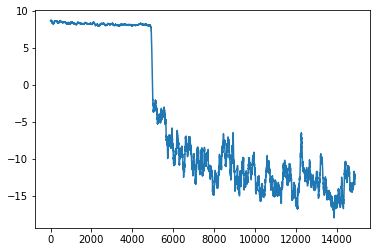

-4.83744860567


In [30]:
# plt.plot(rewards1)
plt.plot(moving_average(rewards1, 100))
plt.show()
print(np.mean(rewards1))

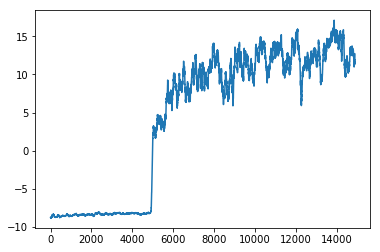

4.33049059549


In [28]:
# plt.plot(rewards2)
plt.plot(moving_average(rewards2, 100))
plt.show()
print(np.mean(rewards2))

In [33]:
#ppo
n_episodes = 5

# test_rewards = []
# agent.saver.restore(agent.sess, "model/model_chaseronly_1000.ckpt")
for i_episode in range(n_episodes):
    env_info = env.reset(train_mode=False)[default_brain]
    state1 = [env_info.states[0]]
    state2 = [env_info.states[1]]
    r1 = r2 = 0
    while True:
#         action1 = np.array([0,0])
        action1 = agent.choose_action(state1)
        action2 = agent2.choose_action(state2)
#         action2 = np.array([0,0])
        env_info = env.step([action1, action2])[default_brain]
        next_state1 = [env_info.states[0]]
        next_state2 = [env_info.states[1]]
        reward1 = env_info.rewards[0]
        reward2 = env_info.rewards[1]
        done = env_info.local_done[0] or env_info.local_done[1]
        if not env_info.local_done[0] and env_info.local_done[1]: # dodger falls but chaser doesn't
            reward1 += 10
        elif not env_info.local_done[1] and env_info.local_done[0]: # chaser falls but dodger doesn't
            reward2 += 10
        r1 += reward1
        r2 += reward2
        state1 = next_state1
        state2 = next_state2
        if done:
            print("episode:", i_episode+1, "rewards: chaser : %.2f, dodger : %.2f" % (r1, r2), end="\r")
#             test_rewards += [r]
            break
print("\n")
print("finished testing!")

episode: 5 rewards: chaser : -22.21, dodger : 21.32

finished testing!


# Train chaser again using dodger

In [26]:
rewards1 = []
rewards2 = []
n_episodes = 5000

agent.saver.restore(agent.sess, "model/model_chaser_5000.ckpt")
agent2.saver.restore(agent2.sess, "model/model_dodger_10000.ckpt")
for i_episode in range(n_episodes):
    env_info = env.reset(train_mode=True)[default_brain]
    state1 = [env_info.states[0]]
    state2 = [env_info.states[1]]
    r1 = r2 = 0
    while True:
        action1 = agent.choose_action(state1)
        action2 = agent2.choose_action(state2, train=False)
        env_info = env.step([action1, action2])[default_brain]
        next_state1 = [env_info.states[0]]
        next_state2 = [env_info.states[1]]
        reward1 = env_info.rewards[0]
        reward2 = env_info.rewards[1]
        done = env_info.local_done[0] or env_info.local_done[1]
        if not env_info.local_done[0] and env_info.local_done[1]: # dodger falls but chaser doesn't
            reward1 += 10
        elif not env_info.local_done[1] and env_info.local_done[0]: # chaser falls but dodger doesn't
            reward2 += 10
        r1 += reward1
        r2 += reward2
        agent.remember(state1, action1, reward1, next_state1)
#         agent2.remember(state2, action2, reward2, next_state2)
        state1 = next_state1
        state2 = next_state2
        if done:
            print("episode:", i_episode+1, "rewards: chaser : %.2f, dodger : %.2f" % (r1, r2), end="\r")
            agent.process_memory()
            rewards1 += [r1]
            rewards2 += [r2]
            break
    if (i_episode+1) % agent.agents == 0: # update every n_agent episodes
        agent.replay()
    if (i_episode+1) % 1000 == 0:
        agent.saver.save(agent.sess, "model/model_chaser_"+str(i_episode+1)+".ckpt");
print("\n")
print("finished learning!")

INFO:tensorflow:Restoring parameters from model/model_chaser_5000.ckpt


INFO:tensorflow:Restoring parameters from model/model_chaser_5000.ckpt


INFO:tensorflow:Restoring parameters from model/model_dodger_10000.ckpt


INFO:tensorflow:Restoring parameters from model/model_dodger_10000.ckpt


INFO:tensorflow:model/model_chaser_1000.ckpt is not in all_model_checkpoint_paths. Manually adding it. chaser : 8.12, dodger : -8.22 339 rewards: chaser : 8.76, dodger : -8.85 348 rewards: chaser : 8.18, dodger : -8.28 359 rewards: chaser : 6.87, dodger : -6.97 363 rewards: chaser : 6.91, dodger : -7.03 489 rewards: chaser : 9.21, dodger : -9.29 594 rewards: chaser : 9.29, dodger : -9.35 645 rewards: chaser : 5.58, dodger : -5.74 670 rewards: chaser : 8.41, dodger : -8.51 680 rewards: chaser : 6.73, dodger : -6.84 772 rewards: chaser : 6.32, dodger : -6.47 940 rewards: chaser : 6.79, dodger : -6.91 976 rewards: chaser : 9.11, dodger : -9.14


INFO:tensorflow:model/model_chaser_1000.ckpt is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model_chaser_2000.ckpt is not in all_model_checkpoint_paths. Manually adding it.rewards: chaser : 9.40, dodger : -9.43 1104 rewards: chaser : 7.68, dodger : -7.74 1306 rewards: chaser : 9.07, dodger : -9.13 1313 rewards: chaser : 6.13, dodger : -6.24 1324 rewards: chaser : 7.09, dodger : -7.21 1447 rewards: chaser : 5.82, dodger : -5.97 1485 rewards: chaser : 9.97, dodger : -9.97 1536 rewards: chaser : 6.74, dodger : -6.84 1550 rewards: chaser : 9.47, dodger : -9.53 1678 rewards: chaser : 8.50, dodger : -8.56 1701 rewards: chaser : 9.02, dodger : -9.09 1729 rewards: chaser : 7.57, dodger : -7.68 1807 rewards: chaser : 6.35, dodger : -6.51


INFO:tensorflow:model/model_chaser_2000.ckpt is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model_chaser_3000.ckpt is not in all_model_checkpoint_paths. Manually adding it.rds: chaser : 8.88, dodger : -8.95 2155 rewards: chaser : 6.46, dodger : -6.56 2175 rewards: chaser : 8.12, dodger : -8.21rewards: chaser : 7.60, dodger : -7.702322 rewards: chaser : 8.64, dodger : -8.72 2393 rewards: chaser : 9.97, dodger : -9.97 2538 rewards: chaser : 6.84, dodger : -6.952545 rewards: chaser : 9.29, dodger : -9.37 2580 rewards: chaser : 8.96, dodger : -9.04 rewards: chaser : 7.34, dodger : -7.45 2660 rewards: chaser : 8.01, dodger : -8.10 2773 rewards: chaser : 6.46, dodger : -6.59 2834 rewards: chaser : 7.75, dodger : -7.84 2883 rewards: chaser : 6.53, dodger : -6.62 2904 rewards: chaser : 7.96, dodger : -8.06 2970 rewards: chaser : 6.48, dodger : -6.60


INFO:tensorflow:model/model_chaser_3000.ckpt is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model_chaser_4000.ckpt is not in all_model_checkpoint_paths. Manually adding it.ds: chaser : 8.20, dodger : -8.29rewards: chaser : 8.57, dodger : -8.64 3336 rewards: chaser : 7.53, dodger : -7.63 3475 rewards: chaser : 7.87, dodger : -7.97 3493 rewards: chaser : 6.88, dodger : -6.99 3504 rewards: chaser : 7.54, dodger : -7.64 3507 rewards: chaser : 6.89, dodger : -6.99 3561 rewards: chaser : 9.01, dodger : -9.08rewards: chaser : -10.36, dodger : 10.41 3588 rewards: chaser : 7.70, dodger : -7.803591 rewards: chaser : 8.88, dodger : -8.95 rewards: chaser : 9.17, dodger : -9.25 3690 rewards: chaser : 9.82, dodger : -9.86 3749 rewards: chaser : -11.10, dodger : 11.16 3752 rewards: chaser : 8.65, dodger : -8.733765 rewards: chaser : 8.18, dodger : -8.28 3807 rewards: chaser : 9.40, dodger : -9.443893 rewards: chaser : 6.85, dodger : -6.90 3959 rewards: chaser : 7.78, dodger : -7.87


INFO:tensorflow:model/model_chaser_4000.ckpt is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model_chaser_5000.ckpt is not in all_model_checkpoint_paths. Manually adding it.9 rewards: chaser : 8.72, dodger : -8.80 4271 rewards: chaser : 9.37, dodger : -9.38 4331 rewards: chaser : 9.15, dodger : -9.21 4465 rewards: chaser : 8.28, dodger : -8.35 4756 rewards: chaser : 9.42, dodger : -9.46 4759 rewards: chaser : 8.02, dodger : -8.11 4761 rewards: chaser : 8.42, dodger : -8.50rewards: chaser : 8.19, dodger : -8.29 4871 rewards: chaser : 6.51, dodger : -6.62 4894 rewards: chaser : 8.62, dodger : -8.71 4920 rewards: chaser : 8.87, dodger : -8.92 4928 rewards: chaser : 7.70, dodger : -7.76 4949 rewards: chaser : 8.50, dodger : -8.60


INFO:tensorflow:model/model_chaser_5000.ckpt is not in all_model_checkpoint_paths. Manually adding it.




finished learning!


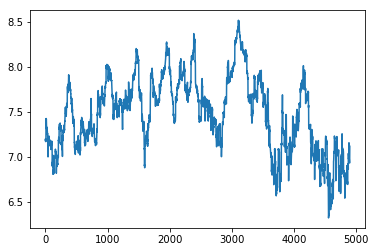

7.4721596474


In [27]:
plt.plot(moving_average(rewards1, 100))
plt.show()
print(np.mean(rewards1))

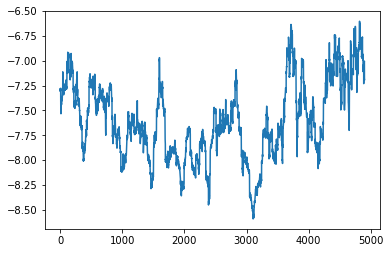

-7.59752442293


In [28]:
plt.plot(moving_average(rewards2, 100))
plt.show()
print(np.mean(rewards2))

In [32]:
n_episodes = 10

# test_rewards = []
# agent.saver.restore(agent.sess, "model/model_chaseronly_1000.ckpt")
for i_episode in range(n_episodes):
    env_info = env.reset(train_mode=False)[default_brain]
    state1 = [env_info.states[0]]
    state2 = [env_info.states[1]]
    r1 = r2 = 0
    while True:
#         action1 = np.array([0,0])
        action1 = agent.choose_action(state1, train=False)
        action2 = agent2.choose_action(state2, train=False)
#         action2 = np.array([0,0])
        env_info = env.step([action1, action2])[default_brain]
        next_state1 = [env_info.states[0]]
        next_state2 = [env_info.states[1]]
        reward1 = env_info.rewards[0]
        reward2 = env_info.rewards[1]
        done = env_info.local_done[0] or env_info.local_done[1]
        if not env_info.local_done[0] and env_info.local_done[1]: # dodger falls but chaser doesn't
            reward1 += 10
        elif not env_info.local_done[1] and env_info.local_done[0]: # chaser falls but dodger doesn't
            reward2 += 10
        r1 += reward1
        r2 += reward2
        state1 = next_state1
        state2 = next_state2
        if done:
            print("episode:", i_episode+1, "rewards: chaser : %.2f, dodger : %.2f" % (r1, r2), end="\r")
#             test_rewards += [r]
            break
print("\n")
print("finished testing!")

episode: 9 rewards: chaser : 9.09, dodger : -9.1310 rewards: chaser : 9.25, dodger : -9.33

finished testing!


# Train dodger again using chaser2

In [57]:
# rewards1 = []
# rewards2 = []
n_episodes = 10000

# agent.saver.restore(agent.sess, "model/model_chaser_5000.ckpt")
# agent2.saver.restore(agent2.sess, "model/model_dodger2_5000.ckpt")

for i_episode in range(n_episodes):
    env_info = env.reset(train_mode=True)[default_brain]
    state1 = [env_info.states[0]]
    state2 = [env_info.states[1]]
    r1 = r2 = 0
    while True:
        action1 = agent.choose_action(state1, train=False)
        action2 = agent2.choose_action(state2)
#         action2 = np.array([0,0])
        env_info = env.step([action1, action2])[default_brain]
        next_state1 = [env_info.states[0]]
        next_state2 = [env_info.states[1]]
        reward1 = env_info.rewards[0]
        reward2 = env_info.rewards[1]
        done = env_info.local_done[0] or env_info.local_done[1]
        if not env_info.local_done[0] and env_info.local_done[1]: # dodger falls but chaser doesn't
            reward1 += 10
        elif not env_info.local_done[1] and env_info.local_done[0]: # chaser falls but dodger doesn't
            reward2 += 10
        r1 += reward1
        r2 += reward2
#         agent.remember(state1, action1, reward1, next_state1)
        agent2.remember(state2, action2, reward2, next_state2)
        state1 = next_state1
        state2 = next_state2
        if done:
            print("episode:", i_episode+1, "rewards: chaser : %.2f, dodger : %.2f" % (r1, r2), end="\r")
            agent2.process_memory()
            rewards1 += [r1]
            rewards2 += [r2]
            break
    if (i_episode+1) % agent.agents == 0: # update every n_agent episodes
        agent2.replay()
    if (i_episode+1) % 10000 == 0:
        agent2.saver.save(agent2.sess, "model/model_dodger2_"+str(i_episode+1)+".ckpt");
# agent.saver.save(agent.sess, "model/model_chaser_"+str(i_episode+1)+".ckpt");
print("\n")
print("finished learning!")

INFO:tensorflow:model/model_dodger2_20000.ckpt is not in all_model_checkpoint_paths. Manually adding it.: chaser : 6.57, dodger : -6.68 255 rewards: chaser : 7.82, dodger : -7.90 262 rewards: chaser : 7.24, dodger : -7.30485 rewards: chaser : 9.66, dodger : -9.67 554 rewards: chaser : 9.57, dodger : -9.61 578 rewards: chaser : 9.02, dodger : -9.06663 rewards: chaser : 8.23, dodger : -8.28 685 rewards: chaser : 8.35, dodger : -8.41 692 rewards: chaser : 6.04, dodger : -6.13 730 rewards: chaser : 5.96, dodger : -6.06739 rewards: chaser : 4.98, dodger : -5.08 780 rewards: chaser : 8.49, dodger : -8.58 915 rewards: chaser : 7.56, dodger : -7.60 919 rewards: chaser : 7.65, dodger : -7.72977 rewards: chaser : 6.98, dodger : -7.06 999 rewards: chaser : 8.60, dodger : -8.68 1027 rewards: chaser : 6.73, dodger : -6.81 1262 rewards: chaser : 8.96, dodger : -8.98 1385 rewards: chaser : 8.58, dodger : -8.68 1390 rewards: chaser : 8.50, dodger : -8.55 rewards: chaser : 9.27, dodger : -9.32 1509 rew

INFO:tensorflow:model/model_dodger2_20000.ckpt is not in all_model_checkpoint_paths. Manually adding it.




finished learning!


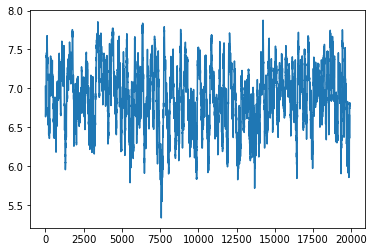

6.88421275346


In [58]:
plt.plot(moving_average(rewards1, 100))
plt.show()
print(np.mean(rewards1))

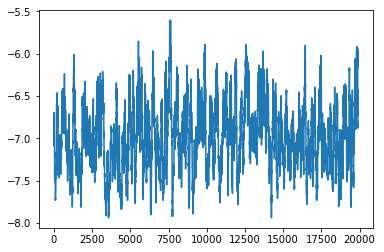

-6.97257593406


In [59]:
plt.plot(moving_average(rewards2, 100))
plt.show()
print(np.mean(rewards2))

In [61]:
n_episodes = 10

# test_rewards = []
# agent.saver.restore(agent.sess, "model/model_chaser_5000.ckpt")
# agent2.saver.restore(agent2.sess, "model/model_dodger2_1000.ckpt")
for i_episode in range(n_episodes):
    env_info = env.reset(train_mode=False)[default_brain]
    state1 = [env_info.states[0]]
    state2 = [env_info.states[1]]
    r1 = r2 = 0
    while True:
        action1 = agent.choose_action(state1, train=False)
        action2 = agent2.choose_action(state2)
        env_info = env.step([action1, action2])[default_brain]
        next_state1 = [env_info.states[0]]
        next_state2 = [env_info.states[1]]
        reward1 = env_info.rewards[0]
        reward2 = env_info.rewards[1]
        done = env_info.local_done[0] or env_info.local_done[1]
        if not env_info.local_done[0] and env_info.local_done[1]: # dodger falls but chaser doesn't
            reward1 += 10
        elif not env_info.local_done[1] and env_info.local_done[0]: # chaser falls but dodger doesn't
            reward2 += 10
        r1 += reward1
        r2 += reward2
        state1 = next_state1
        state2 = next_state2
        if done:
            print("episode:", i_episode+1, "rewards: chaser : %.2f, dodger : %.2f" % (r1, r2), end="\r")
#             test_rewards += [r]
            break
print("\n")
print("finished testing!")

episode: 10 rewards: chaser : 7.38, dodger : -7.44

finished testing!


# Train together

In [7]:
rewards1 = []
rewards2 = []
n_episodes = 1000

agent.saver.restore(agent.sess, "model/model_chaser_5000.ckpt")
agent2.saver.restore(agent2.sess, "model/model_dodger2_1000.ckpt")

for i_episode in range(n_episodes):
    env_info = env.reset(train_mode=True)[default_brain]
    state1 = [env_info.states[0]]
    state2 = [env_info.states[1]]
    r1 = r2 = 0
    while True:
        action1 = agent.choose_action(state1)
        action2 = agent2.choose_action(state2)
        env_info = env.step([action1, action2])[default_brain]
        next_state1 = [env_info.states[0]]
        next_state2 = [env_info.states[1]]
        reward1 = env_info.rewards[0]
        reward2 = env_info.rewards[1]
        done = env_info.local_done[0] or env_info.local_done[1]
        if not env_info.local_done[0] and env_info.local_done[1]: # dodger falls but chaser doesn't
            reward1 += 10
        elif not env_info.local_done[1] and env_info.local_done[0]: # chaser falls but dodger doesn't
            reward2 += 10
        r1 += reward1
        r2 += reward2
        agent.remember(state1, action1, reward1, next_state1)
        agent2.remember(state2, action2, reward2, next_state2)
        state1 = next_state1
        state2 = next_state2
        if done:
            print("episode:", i_episode+1, "rewards: chaser : %.2f, dodger : %.2f" % (r1, r2), end="\r")
            agent.process_memory()
            agent2.process_memory()
            rewards1 += [r1]
            rewards2 += [r2]
            break
    if (i_episode+1) % agent.agents == 0: # update every n_agent episodes
        agent.replay()
        agent2.replay()
    if (i_episode+1) % 1000 == 0:
        agent.saver.save(agent2.sess, "model/model_together_chaser_"+str(i_episode+1)+".ckpt");
        agent2.saver.save(agent2.sess, "model/model_together_dodger_"+str(i_episode+1)+".ckpt");
print("\n")
print("finished learning!")

INFO:tensorflow:Restoring parameters from model/model_chaser_5000.ckpt


INFO:tensorflow:Restoring parameters from model/model_chaser_5000.ckpt


INFO:tensorflow:Restoring parameters from model/model_dodger_10000.ckpt


INFO:tensorflow:Restoring parameters from model/model_dodger_10000.ckpt


INFO:tensorflow:model/model_together_chaser_1000.ckpt is not in all_model_checkpoint_paths. Manually adding it. : 7.37, dodger : -7.44 189 rewards: chaser : 9.74, dodger : -9.74 257 rewards: chaser : 7.15, dodger : -7.28rewards: chaser : 7.09, dodger : -7.17 429 rewards: chaser : 6.55, dodger : -6.67 475 rewards: chaser : 9.56, dodger : -9.58 662 rewards: chaser : 7.16, dodger : -7.22 749 rewards: chaser : 6.61, dodger : -6.70 775 rewards: chaser : 6.34, dodger : -6.49 849 rewards: chaser : 5.20, dodger : -5.29 872 rewards: chaser : 7.20, dodger : -7.28885 rewards: chaser : 6.52, dodger : -6.63 rewards: chaser : 5.64, dodger : -5.76


INFO:tensorflow:model/model_together_chaser_1000.ckpt is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model_together_dodger_1000.ckpt is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:model/model_together_dodger_1000.ckpt is not in all_model_checkpoint_paths. Manually adding it.




finished learning!


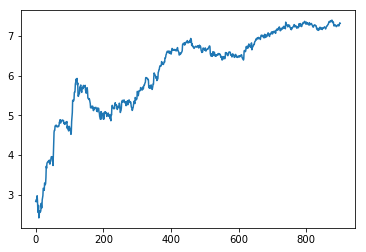

In [8]:
plt.plot(moving_average(rewards1, 100))
plt.show()

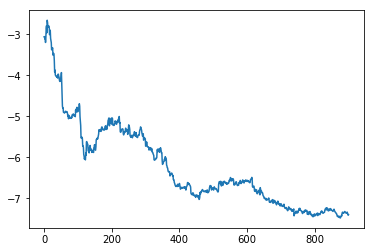

In [9]:
plt.plot(moving_average(rewards2, 100))
plt.show()

In [11]:
np.mean(np.asarray(rewards1)>0)

0.93400000000000005

In [25]:
n_episodes = 10

# test_rewards = []
agent.saver.restore(agent.sess, "model/model_chaser_5000.ckpt")
agent2.saver.restore(agent2.sess, "model/model_dodger2_1000.ckpt")

for i_episode in range(n_episodes):
    env_info = env.reset(train_mode=False)[default_brain]
    state1 = [env_info.states[0]]
    state2 = [env_info.states[1]]
    r1 = r2 = 0
    while True:
#         action1 = np.array([0,0])
        action1 = agent.choose_action(state1)
        action2 = agent2.choose_action(state2)
#         action2 = np.array([0,0])
        env_info = env.step([action1, action2])[default_brain]
        next_state1 = [env_info.states[0]]
        next_state2 = [env_info.states[1]]
        reward1 = env_info.rewards[0]
        reward2 = env_info.rewards[1]
        done = env_info.local_done[0] or env_info.local_done[1]
        if not env_info.local_done[0] and env_info.local_done[1]: # dodger falls but chaser doesn't
            reward1 += 10
        elif not env_info.local_done[1] and env_info.local_done[0]: # chaser falls but dodger doesn't
            reward2 += 10
        r1 += reward1
        r2 += reward2
        state1 = next_state1
        state2 = next_state2
        if done:
            print("episode:", i_episode+1, "rewards: chaser : %.2f, dodger : %.2f" % (r1, r2), end="\r")
#             test_rewards += [r]
            break
print("\n")
print("finished testing!")

INFO:tensorflow:Restoring parameters from model/model_chaser_5000.ckpt


INFO:tensorflow:Restoring parameters from model/model_chaser_5000.ckpt


INFO:tensorflow:Restoring parameters from model/model_dodger2_1000.ckpt


INFO:tensorflow:Restoring parameters from model/model_dodger2_1000.ckpt


episode: 10 rewards: chaser : 5.07, dodger : -5.203

finished testing!


In [19]:
env.close()